# Modern Portfolio Theory

## Import Libraries

In [83]:
# Import pandas & yfinance
# Import numpy
from pathlib import Path

import numpy as np
import pandas as pd
import yfinance as yf
from numpy.linalg import multi_dot

# Set numpy random seed
np.random.seed(23)

In [82]:
import cufflinks as cf

cf.set_config_file(offline=True, theme="solar", dimensions=((1000, 600)))
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = pio.templates["plotly_dark"]

px.defaults.width, px.defaults.height = 1000, 600

In [84]:
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

## Retrive Data

In [85]:
# Specify assets / stocks
# international etf portfolio : 'SPY', 'GLD', 'IWM', 'VWO', 'BND']

# indian stocks : bank, consumer goods, diversified, it, consumer durables
# ['HDFCBANK', 'ITC', 'RELIANCE', 'TCS', 'ASIANPAINT']

assets = ["HDFCBANK", "ITC", "RELIANCE", "TCS", "ASIANPAINT"]
assets.sort()

# Number of assets
numofasset = len(assets)

# Number of portfolio for optimization
numofportfolio = 5000

In [152]:
# Get yahoo tickers for indian stocks
df_path = Path("data/india_stocks.csv")

if df_path.exists():
    # Read from file
    df = pd.read_csv(df_path, index_col=0, parse_dates=True)
else:
    df_path.parent.mkdir(parents=True, exist_ok=True)
    yahooticker = [x + ".NS" for x in assets]

    # Fetch / read data for multiple stocks at once
    df = yf.download(yahooticker, start="2015-01-01", end="2022-12-31", progress=False)[
        "Adj Close"
    ]
    df.columns = assets

    # write data to file for future use
    df.to_csv(df_path)

# Display dataframe
df

,ASIANPAINT,HDFCBANK,ITC,RELIANCE,TCS
Date,,,,,
2015-01-01 00:00:00+05:30,704.9195,446.3565,191.1795,417.9889,1065.1387
2015-01-02 00:00:00+05:30,729.2903,452.5686,191.7784,416.8826,1079.3236
2015-01-05 00:00:00+05:30,729.2432,448.7476,192.5334,412.3163,1062.9208
2015-01-06 00:00:00+05:30,711.8356,441.7619,187.5866,393.6035,1023.7350
2015-01-07 00:00:00+05:30,726.1381,443.0511,184.0978,402.1714,1011.6425
...,...,...,...,...,...
2022-12-26 00:00:00+05:30,3035.8335,1610.9755,327.3880,2524.0500,3156.5701
2022-12-27 00:00:00+05:30,3092.0093,1612.6068,325.9692,2544.7000,3162.9751
2022-12-28 00:00:00+05:30,3103.0359,1611.3215,327.1923,2544.4500,3160.6460


In [194]:
def annualize(data, rrtype):
    tdpy = 260
    if rrtype == 0:
        return data * tdpy
    if rrtype == 1:
        return data * np.sqrt(tdpy)
    raise ValueError(rrtype)

## Visualize Time Series

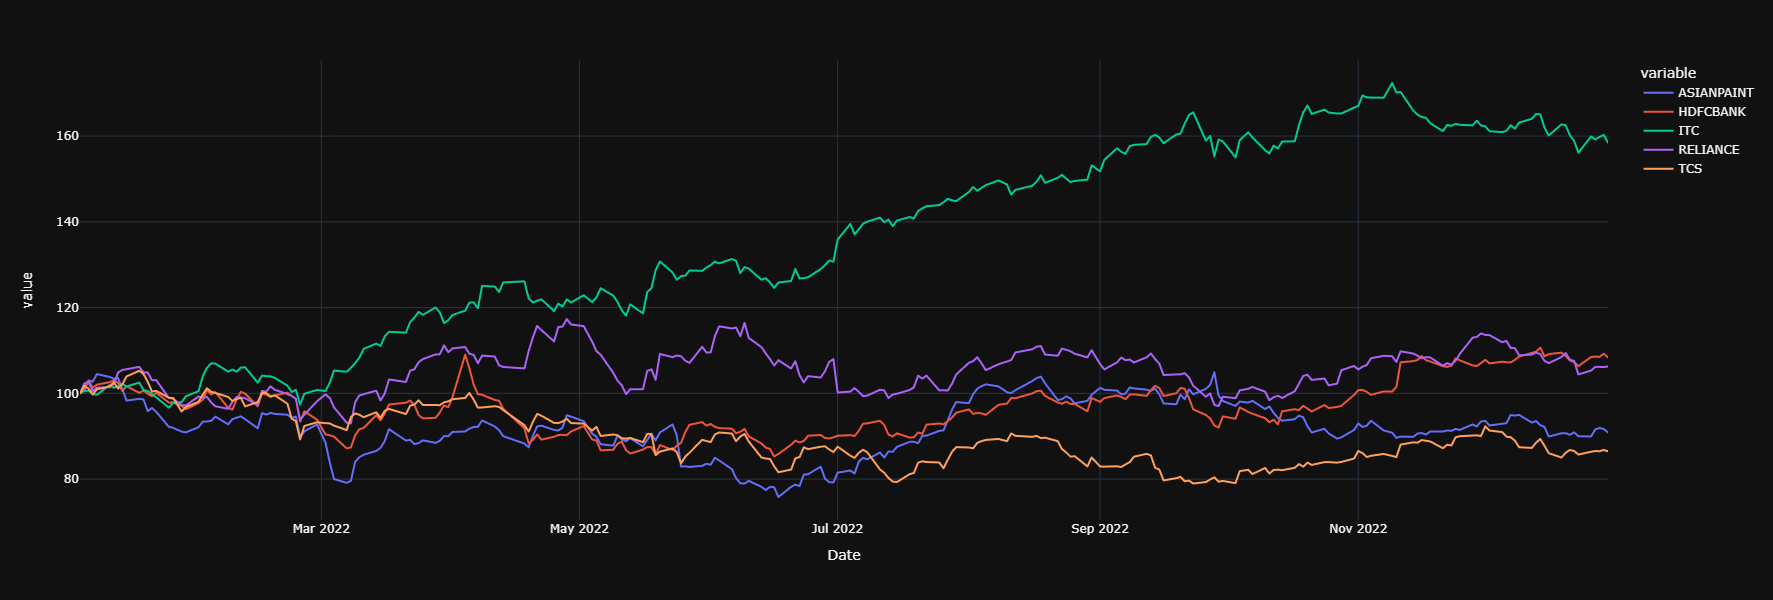

In [195]:
# Plot price history
# df["2022":].normalize().iplot(kind="line")
df["2022":].normalize().pipe(px.line)

In [196]:
# Dataframe of returns and volatility


def get_returns(df):
    returns = df.pct_change().dropna()
    annual_returns = annualize(returns.mean(), 0).round(4) * 100
    annual_stdev = annualize(returns.std(), 1).round(4) * 100
    return pd.DataFrame(
        {
            "Ann Ret": annual_returns,
            "Ann Vol": annual_stdev,
        }
    )


df1 = get_returns(df)
df1

,Ann Ret,Ann Vol
ASIANPAINT,22.98,26.88
HDFCBANK,19.71,23.75
ITC,10.63,27.00
RELIANCE,28.23,29.81
TCS,17.39,24.77


In [155]:
# Chart above show that ITC has best performance, but the table shows worst
# Reason is that chart is only for last year, but the table was form all the time
get_returns(df["2022":])

,Ann Ret,Ann Vol
ASIANPAINT,-6.33,27.27
HDFCBANK,11.81,25.98
ITC,50.72,21.16
RELIANCE,10.05,27.01
TCS,-12.50,23.59


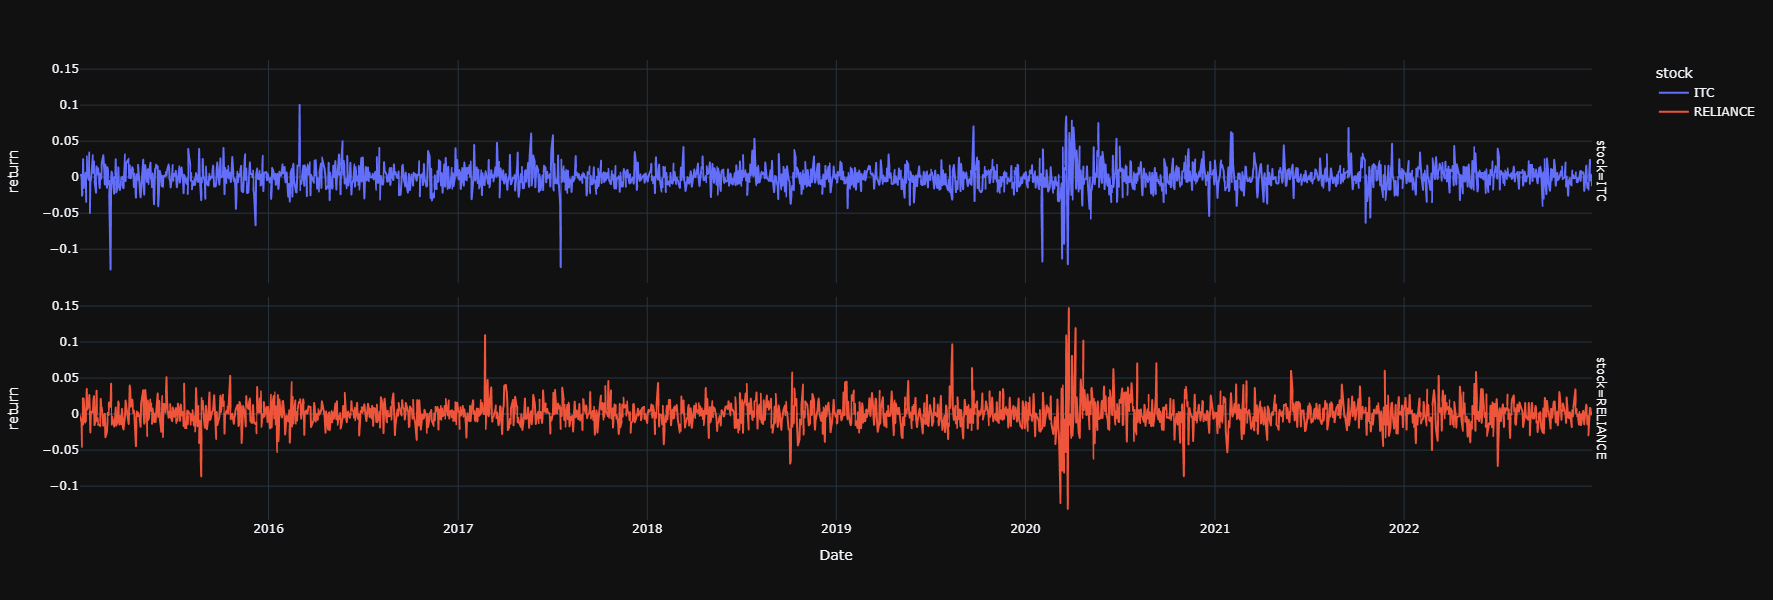

In [188]:
(
    df.pct_change()
    .dropna()
    .loc[:, ["ITC", "RELIANCE"]]
    .melt(var_name="stock", value_name="return", ignore_index=False)
    .assign(year=lambda ldf: ldf.index.to_series().dt.year)
    # .assign(day=lambda ldf: ldf.index.to_series().dt.day_of_year)
    .pipe(
        px.line,
        # x="day",
        y="return",
        # facet_col="year",
        facet_row="stock",
        color="stock",
    )
)

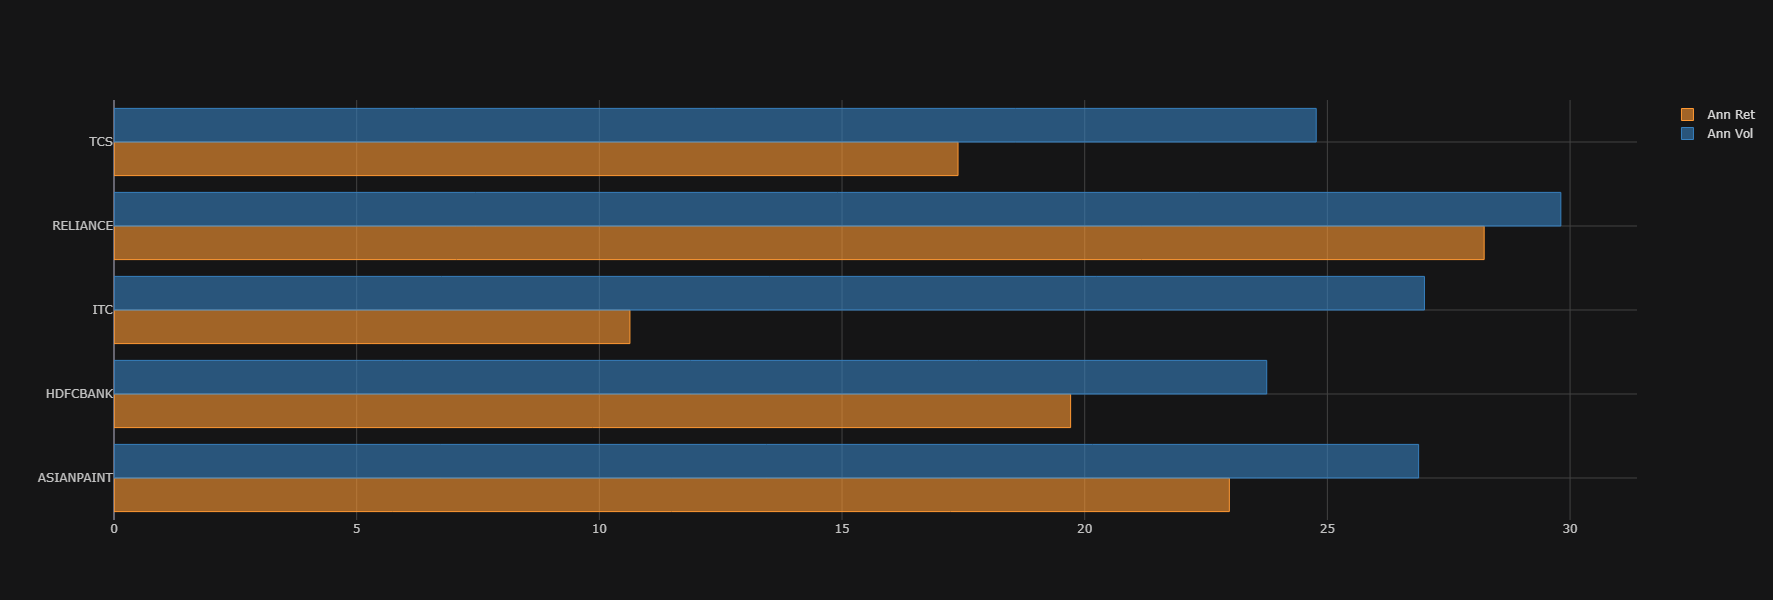

In [189]:
# Plot annualized return and volatility
df1.iplot(kind="bar", shared_xaxes=True, orientation="h")

## Portfolio Composition

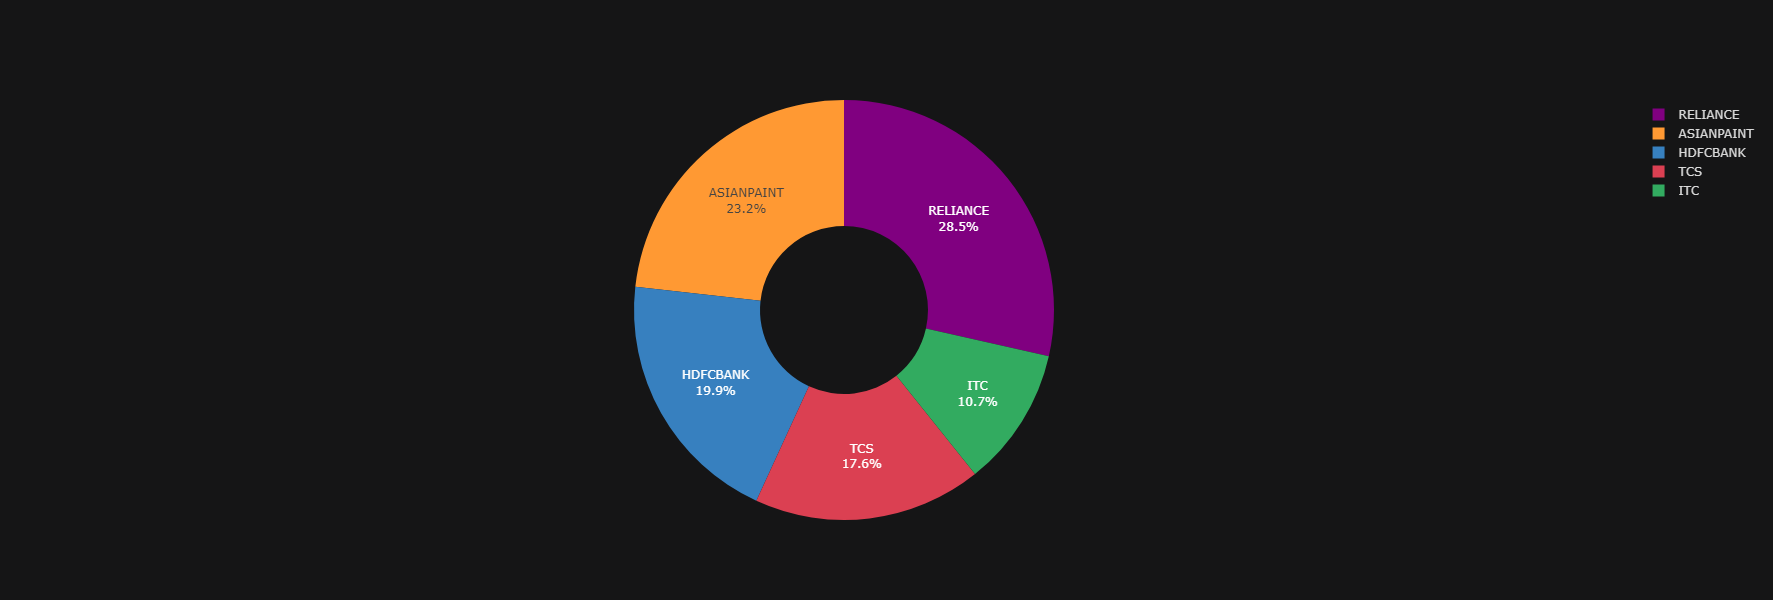

In [190]:
df1.reset_index().iplot(
    kind="pie", labels="index", values="Ann Ret", textinfo="percent+label", hole=0.4
)

## Portfolio Statistics

### Portfolio Simulation

In [200]:
def portfolio_simulation(returns):
    # Initialize the lists
    rets = []
    vols = []
    wts = []

    # Simulate 5,000 portfolios
    for i in range(numofportfolio):
        # Generate random weights
        weights = np.random.random(numofasset)

        # Set weights such that sum of weights equals 1
        weights /= np.sum(weights)

        # Portfolio statistics
        rets.append(weights.T @ np.array(annualize(returns.mean(), 0)))
        vols.append(
            np.sqrt(multi_dot([weights.T, annualize(returns.cov(), 0), weights]))
        )
        wts.append(weights)

    # Create a dataframe for analysis
    data = {"port_rets": rets, "port_vols": vols}
    for counter, symbol in enumerate(returns.columns.tolist()):
        data[symbol + " weight"] = [w[counter] for w in wts]

    portdf = pd.DataFrame(data)
    portdf["sharpe_ratio"] = portdf["port_rets"] / portdf["port_vols"]
    return round(portdf, 4)

### Maximum Sharpe Portfolio

In [203]:
# Create a dataframe for analysis
temp = portfolio_simulation(returns)
temp.head()

,port_rets,port_vols,ASIANPAINT weight,HDFCBANK weight,ITC weight,RELIANCE weight,TCS weight,sharpe_ratio
0,0.2024,0.1730,0.2197,0.1322,0.1578,0.2196,0.2707,1.1701
1,0.2065,0.1787,0.3343,0.1022,0.1841,0.2212,0.1582,1.1554
2,0.2154,0.1918,0.0551,0.1102,0.0615,0.3695,0.4037,1.1230
3,0.2405,0.2116,0.3590,0.0179,0.0886,0.4807,0.0539,1.1365
4,0.1894,0.1738,0.0559,0.3063,0.2254,0.1895,0.2228,1.0902


In [204]:
temp.iloc[temp.sharpe_ratio.idxmax()]

port_rets            0.2219
port_vols            0.1825
ASIANPAINT weight    0.2893
HDFCBANK weight      0.2023
ITC weight           0.0156
RELIANCE weight      0.2597
TCS weight           0.2331
sharpe_ratio         1.2158
Name: 4823, dtype: float64

In [205]:
# Verify the above result
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
port_rets,5000.0,0.1978,0.0167,0.1320,0.1867,0.1979,0.2091,0.2610
port_vols,5000.0,0.1808,0.0089,0.1677,0.1744,0.1790,0.1853,0.2511
ASIANPAINT weight,5000.0,0.2003,0.1140,0.0000,0.1112,0.2008,0.2777,0.7521
HDFCBANK weight,5000.0,0.1985,0.1128,0.0000,0.1090,0.2004,0.2760,0.6380
ITC weight,5000.0,0.2019,0.1145,0.0004,0.1128,0.2020,0.2777,0.8092
RELIANCE weight,5000.0,0.2006,0.1126,0.0000,0.1134,0.2002,0.2773,0.7585
TCS weight,5000.0,0.1986,0.1149,0.0000,0.1051,0.1963,0.2785,0.7187
sharpe_ratio,5000.0,1.0945,0.0796,0.5635,1.0534,1.1099,1.1535,1.2158


### Visulaize Simulated Portfolio

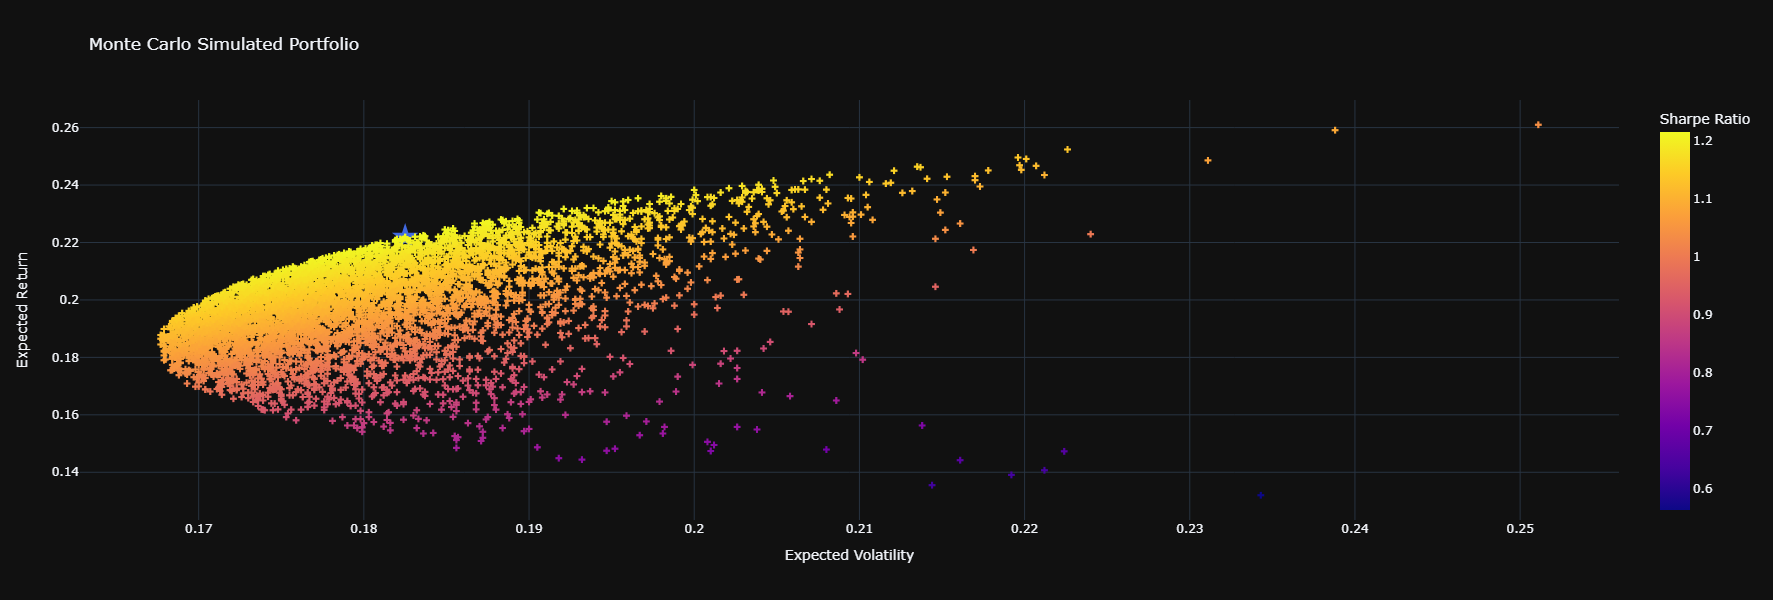

In [206]:
# Plot simulated portfolio
fig = px.scatter(
    temp,
    x="port_vols",
    y="port_rets",
    color="sharpe_ratio",
    labels={
        "port_vols": "Expected Volatility",
        "port_rets": "Expected Return",
        "sharpe_ratio": "Sharpe Ratio",
    },
    title="Monte Carlo Simulated Portfolio",
).update_traces(mode="markers", marker=dict(symbol="cross"))

# Plot max sharpe
fig.add_scatter(
    mode="markers",
    x=[temp.iloc[temp.sharpe_ratio.idxmax()]["port_vols"]],
    y=[temp.iloc[temp.sharpe_ratio.idxmax()]["port_rets"]],
    marker=dict(color="RoyalBlue", size=20, symbol="star"),
    name="Max Sharpe",
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

## Efficient Frontier

### Constrained Optimization

In [207]:
# Import optimization module from scipy
# sco.minimize?
import scipy.optimize as sco

### Portfolio Statistics

In [209]:
def portfolio_stats(weights):
    weights = np.array(weights)
    port_rets = weights.T @ annualize(returns.mean(), 0)
    port_vols = np.sqrt(multi_dot([weights.T, annualize(returns.cov(), 0), weights]))
    return np.array([port_rets, port_vols, port_rets / port_vols])


# Minimize the volatility
def min_volatility(weights):
    return portfolio_stats(weights)[1]


# Minimize the variance
def min_variance(weights):
    return portfolio_stats(weights)[1] ** 2


# Maximizing sharpe ratio
def max_sharpe_ratio(weights):
    return -portfolio_stats(weights)[2]

### Efficient Frontier Portfolio

In [210]:
# Specify constraints, bounds and initial weights
cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bnds = tuple((0, 1) for x in range(numofasset))
initial_wts = numofasset * [1.0 / numofasset]

In [211]:
# Optimizing for maximum sharpe ratio
opt_sharpe = sco.minimize(
    max_sharpe_ratio, initial_wts, method="SLSQP", bounds=bnds, constraints=cons
)
# Optimizing for minimum variance
opt_var = sco.minimize(
    min_variance, initial_wts, method="SLSQP", bounds=bnds, constraints=cons
)

In [212]:
opt_sharpe

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.2178093043961684
       x: [ 2.738e-01  2.292e-01  0.000e+00  2.793e-01  2.176e-01]
     nit: 6
     jac: [-3.827e-04  1.388e-04  3.090e-02  3.885e-05  2.855e-04]
    nfev: 36
    njev: 6

In [213]:
opt_var

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.02804007986976958
       x: [ 1.928e-01  2.367e-01  2.099e-01  7.286e-02  2.878e-01]
     nit: 7
     jac: [ 5.615e-02  5.592e-02  5.597e-02  5.613e-02  5.623e-02]
    nfev: 42
    njev: 7

In [216]:
# Efficient Frontier
targetrets = np.linspace(0.155, 0.24, 100)
tvols = []
for tr in targetrets:
    ef_cons = (
        {"type": "eq", "fun": lambda x: portfolio_stats(x)[0] - tr},
        {"type": "eq", "fun": lambda x: np.sum(x) - 1},
    )
    opt_ef = sco.minimize(
        min_volatility, initial_wts, method="SLSQP", bounds=bnds, constraints=ef_cons
    )
    tvols.append(opt_ef["fun"])
targetvols = np.array(tvols)

In [217]:
# Create EF Dataframe for plotting
efport = pd.DataFrame(
    {
        "targetrets": np.around(100 * targetrets, 2),
        "targetvols": np.around(100 * targetvols, 2),
        "targetsharpe": np.around(targetrets / targetvols, 2),
    }
)
efport.head()

,targetrets,targetvols,targetsharpe
0,15.50,17.79,0.87
1,15.59,17.72,0.88
2,15.67,17.65,0.89
3,15.76,17.59,0.90
4,15.84,17.52,0.90


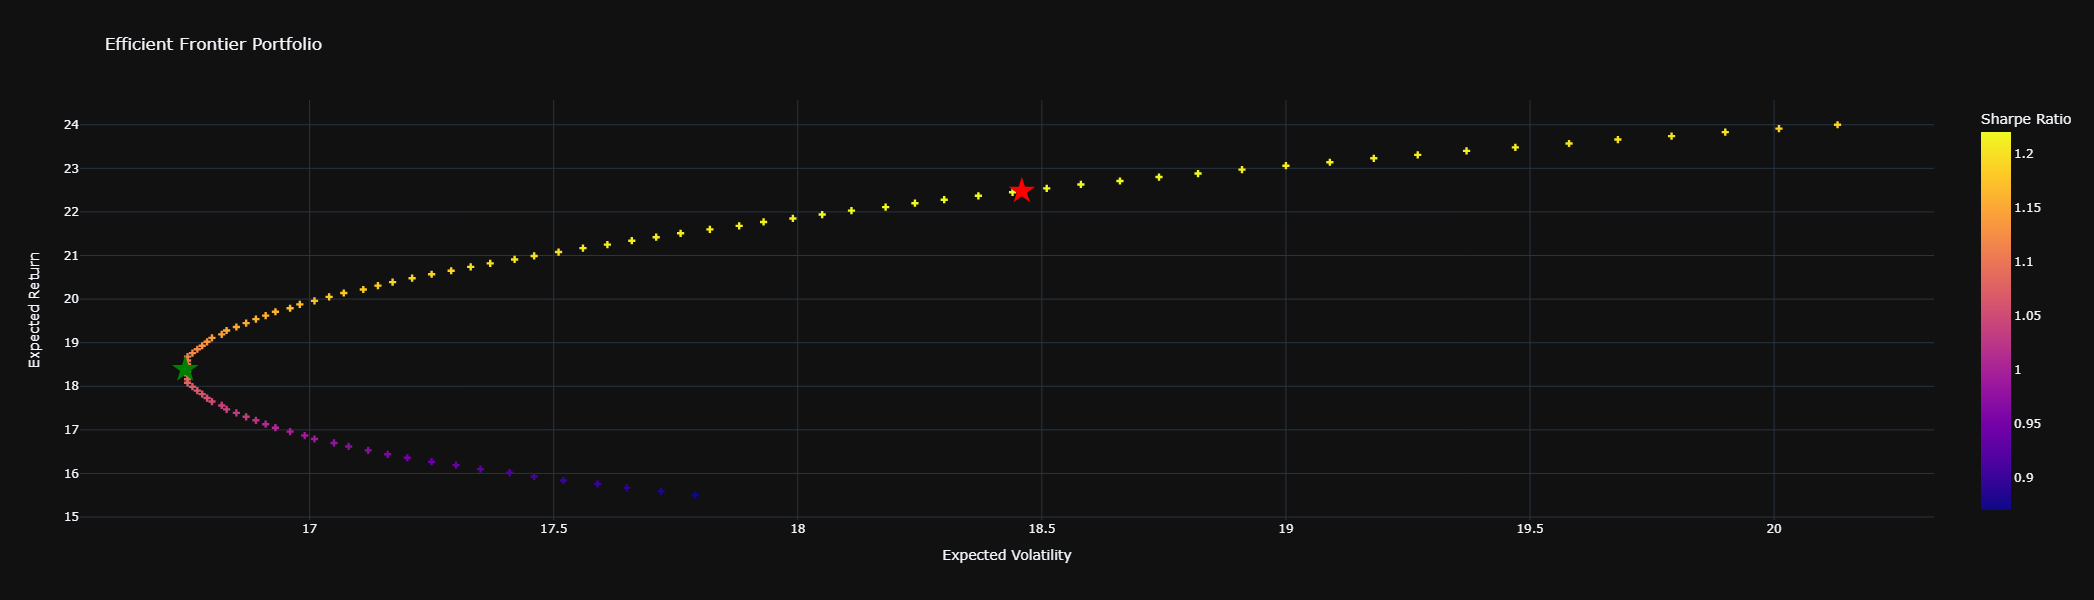

In [220]:
# Plot efficient frontier portfolio
(
    px.scatter(
        efport,
        x="targetvols",
        y="targetrets",
        color="targetsharpe",
        labels={
            "targetrets": "Expected Return",
            "targetvols": "Expected Volatility",
            "targetsharpe": "Sharpe Ratio",
        },
        title="Efficient Frontier Portfolio",
    )
    .update_traces(mode="markers", marker=dict(symbol="cross"))
    .add_scatter(
        # Plot maximum sharpe portfolio
        mode="markers",
        x=[100 * portfolio_stats(opt_sharpe["x"])[1]],
        y=[100 * portfolio_stats(opt_sharpe["x"])[0]],
        marker=dict(color="red", size=20, symbol="star"),
        name="Max Sharpe",
    )
    .update(layout_showlegend=False)
    .add_scatter(
        # Plot minimum variance portfolio
        mode="markers",
        x=[100 * portfolio_stats(opt_var["x"])[1]],
        y=[100 * portfolio_stats(opt_var["x"])[0]],
        marker=dict(color="green", size=20, symbol="star"),
        name="Min Variance",
    )
    .update(layout_showlegend=False)
    .update_xaxes(showspikes=True)
    .update_yaxes(showspikes=True)
)